In [1]:
# Cell 1: Setup
import sys
import os
project_root = os.path.abspath('..')
sys.path.insert(0, project_root)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms

from src.utils.config_loader import ConfigLoader
from src.models import LeNet5
from src.data.dataset import ChestXrayDataset
from src.training.trainer import Trainer

print("✅ Imports successful!")

✅ Imports successful!


In [2]:
# Cell 2: Load configs
loader = ConfigLoader(project_root)

# Load model config
model_config = loader.load_model_config('lenet')
data_config = loader.load_data_config()

print("📋 Model Config:")
print(f"  Name: {model_config['model']['name']}")
print(f"  Epochs: {model_config['training']['num_epochs']}")
print(f"  Batch Size: {model_config['training']['batch_size']}")
print(f"  Learning Rate: {model_config['training']['learning_rate']}")

print("\n📋 Data Config:")
print(f"  Classes: {data_config['data']['classes']}")
print(f"  Image Size: {data_config['data']['image_size']}")

📋 Model Config:
  Name: LeNet-5
  Epochs: 30
  Batch Size: 64
  Learning Rate: 0.001

📋 Data Config:
  Classes: ['COVID-19', 'Normal', 'Pneumonia', 'Tuberculosis']
  Image Size: 224


In [3]:
# Cell 3: Prepare data
norm_type = model_config['data']['normalization']
mean = data_config['data']['normalization'][norm_type]['mean']
std = data_config['data']['normalization'][norm_type]['std']

# Training transforms
train_transform = transforms.Compose([
    transforms.Resize((data_config['data']['image_size'], 
                      data_config['data']['image_size'])),
    transforms.RandomHorizontalFlip() if data_config['data']['augmentation']['horizontal_flip'] else transforms.Lambda(lambda x: x),
    transforms.RandomRotation(data_config['data']['augmentation']['rotation_degrees']),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Val transforms
val_transform = transforms.Compose([
    transforms.Resize((data_config['data']['image_size'], 
                      data_config['data']['image_size'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Create datasets
train_dataset = ChestXrayDataset(
    root_dir=os.path.join(data_config['data']['root_dir'], 'train'),
    transform=train_transform
)

val_dataset = ChestXrayDataset(
    root_dir=os.path.join(data_config['data']['root_dir'], 'val'),
    transform=val_transform
)

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=model_config['training']['batch_size'],
    shuffle=True,
    num_workers=model_config['data']['num_workers'],
    pin_memory=model_config['data']['pin_memory']
)

val_loader = DataLoader(
    val_dataset,
    batch_size=model_config['training']['batch_size'],
    shuffle=False,
    num_workers=model_config['data']['num_workers']
)

print(f"✅ Train: {len(train_dataset)} samples")
print(f"✅ Val: {len(val_dataset)} samples")

📂 Detected classes: ['COVID-19', 'Normal', 'Pneumonia', 'Tuberculosis']
✅ Loaded 11546 images from /home/ducluong/chest-xray-classification/data/processed/train
📂 Detected classes: ['COVID-19', 'Normal', 'Pneumonia', 'Tuberculosis']
✅ Loaded 2471 images from /home/ducluong/chest-xray-classification/data/processed/val
✅ Train: 11546 samples
✅ Val: 2471 samples


In [4]:
# Cell 4: Create model
device = model_config['device'] if torch.cuda.is_available() else 'cpu'

model = LeNet5(num_classes=model_config['model']['num_classes'])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    model.parameters(),
    lr=model_config['training']['learning_rate'],
    weight_decay=model_config['training']['weight_decay']
)

print(f"✅ Model: {model_config['model']['name']}")
print(f"✅ Device: {device}")
print(f"✅ Parameters: {sum(p.numel() for p in model.parameters()):,}")

✅ Model: LeNet-5
✅ Device: cuda
✅ Parameters: 5,612,216


In [5]:
# Cell 5: Train
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    checkpoint_dir=model_config['checkpoint']['save_dir']
)

history = trainer.train(
    num_epochs=model_config['training']['num_epochs'],
    save_best=model_config['checkpoint']['save_best']
)

# Rename checkpoint
import shutil
old_path = os.path.join(model_config['checkpoint']['save_dir'], 'best_model.pth')
new_path = os.path.join(model_config['checkpoint']['save_dir'], f"{model_config['model']['type']}_best.pth")
if os.path.exists(old_path):
    shutil.move(old_path, new_path)
    print(f"✅ Saved: {new_path}")

Training on cuda
Total epochs: 30

Epoch 1/30
------------------------------------------------------------


Validation: 100%|██████████| 39/39 [00:42<00:00,  1.09s/it, loss=0.3, acc=90.1]  



Train Loss: 0.4366 | Train Acc: 84.32%
Val Loss: 0.3001 | Val Acc: 90.08%
✅ Saved best model! (Val Acc: 90.08%)

Epoch 2/30
------------------------------------------------------------


Validation: 100%|██████████| 39/39 [00:40<00:00,  1.03s/it, loss=0.245, acc=92.4]



Train Loss: 0.2766 | Train Acc: 90.64%
Val Loss: 0.2448 | Val Acc: 92.43%
✅ Saved best model! (Val Acc: 92.43%)

Epoch 3/30
------------------------------------------------------------


Validation: 100%|██████████| 39/39 [00:48<00:00,  1.24s/it, loss=0.199, acc=92.9]



Train Loss: 0.2274 | Train Acc: 92.05%
Val Loss: 0.1988 | Val Acc: 92.88%
✅ Saved best model! (Val Acc: 92.88%)

Epoch 4/30
------------------------------------------------------------


Validation: 100%|██████████| 39/39 [00:39<00:00,  1.01s/it, loss=0.175, acc=94.3]



Train Loss: 0.2043 | Train Acc: 92.69%
Val Loss: 0.1749 | Val Acc: 94.33%
✅ Saved best model! (Val Acc: 94.33%)

Epoch 5/30
------------------------------------------------------------


Validation: 100%|██████████| 39/39 [00:40<00:00,  1.04s/it, loss=0.197, acc=93.1]



Train Loss: 0.1889 | Train Acc: 93.32%
Val Loss: 0.1974 | Val Acc: 93.08%

Epoch 6/30
------------------------------------------------------------


Validation: 100%|██████████| 39/39 [01:04<00:00,  1.65s/it, loss=0.226, acc=94.2]



Train Loss: 0.1683 | Train Acc: 94.13%
Val Loss: 0.1740 | Val Acc: 94.21%

Epoch 7/30
------------------------------------------------------------


Validation: 100%|██████████| 39/39 [00:39<00:00,  1.02s/it, loss=0.218, acc=93.5]



Train Loss: 0.1671 | Train Acc: 93.96%
Val Loss: 0.2127 | Val Acc: 93.52%

Epoch 8/30
------------------------------------------------------------


Validation: 100%|██████████| 39/39 [00:21<00:00,  1.84it/s, loss=0.189, acc=93.4]



Train Loss: 0.1546 | Train Acc: 94.47%
Val Loss: 0.1891 | Val Acc: 93.36%

Epoch 9/30
------------------------------------------------------------


Validation: 100%|██████████| 39/39 [00:19<00:00,  2.03it/s, loss=0.177, acc=94.8]



Train Loss: 0.1398 | Train Acc: 94.99%
Val Loss: 0.1633 | Val Acc: 94.82%
✅ Saved best model! (Val Acc: 94.82%)

Epoch 10/30
------------------------------------------------------------


Validation: 100%|██████████| 39/39 [00:19<00:00,  2.05it/s, loss=0.16, acc=94.7] 



Train Loss: 0.1387 | Train Acc: 94.86%
Val Loss: 0.1604 | Val Acc: 94.70%

Epoch 11/30
------------------------------------------------------------


Validation: 100%|██████████| 39/39 [00:30<00:00,  1.29it/s, loss=0.138, acc=95.2]



Train Loss: 0.1291 | Train Acc: 95.43%
Val Loss: 0.1384 | Val Acc: 95.22%
✅ Saved best model! (Val Acc: 95.22%)

Epoch 12/30
------------------------------------------------------------


Validation: 100%|██████████| 39/39 [00:39<00:00,  1.00s/it, loss=0.162, acc=94.7]



Train Loss: 0.1225 | Train Acc: 95.51%
Val Loss: 0.1622 | Val Acc: 94.70%

Epoch 13/30
------------------------------------------------------------


Validation: 100%|██████████| 39/39 [00:20<00:00,  1.87it/s, loss=0.141, acc=94.9]



Train Loss: 0.1180 | Train Acc: 95.96%
Val Loss: 0.1412 | Val Acc: 94.94%

Epoch 14/30
------------------------------------------------------------


Validation: 100%|██████████| 39/39 [00:20<00:00,  1.93it/s, loss=0.201, acc=94.1]



Train Loss: 0.1128 | Train Acc: 95.89%
Val Loss: 0.2011 | Val Acc: 94.05%

Epoch 15/30
------------------------------------------------------------


Validation: 100%|██████████| 39/39 [02:40<00:00,  4.11s/it, loss=0.161, acc=94.7]



Train Loss: 0.1197 | Train Acc: 95.73%
Val Loss: 0.1572 | Val Acc: 94.66%

Epoch 16/30
------------------------------------------------------------


Validation: 100%|██████████| 39/39 [02:00<00:00,  3.08s/it, loss=0.15, acc=94.6] 



Train Loss: 0.1081 | Train Acc: 96.32%
Val Loss: 0.1466 | Val Acc: 94.58%

Epoch 17/30
------------------------------------------------------------


Validation: 100%|██████████| 39/39 [02:26<00:00,  3.76s/it, loss=0.123, acc=95.6]



Train Loss: 0.1043 | Train Acc: 96.28%
Val Loss: 0.1202 | Val Acc: 95.63%
✅ Saved best model! (Val Acc: 95.63%)

Epoch 18/30
------------------------------------------------------------


Validation: 100%|██████████| 39/39 [01:49<00:00,  2.82s/it, loss=0.122, acc=95.2]



Train Loss: 0.0987 | Train Acc: 96.48%
Val Loss: 0.1222 | Val Acc: 95.22%

Epoch 19/30
------------------------------------------------------------


Validation: 100%|██████████| 39/39 [03:18<00:00,  5.08s/it, loss=0.118, acc=95.9]



Train Loss: 0.0935 | Train Acc: 96.80%
Val Loss: 0.1149 | Val Acc: 95.87%
✅ Saved best model! (Val Acc: 95.87%)

Epoch 20/30
------------------------------------------------------------


Validation: 100%|██████████| 39/39 [03:29<00:00,  5.38s/it, loss=0.135, acc=95.7]



Train Loss: 0.0896 | Train Acc: 96.90%
Val Loss: 0.1280 | Val Acc: 95.71%

Epoch 21/30
------------------------------------------------------------


Validation: 100%|██████████| 39/39 [02:08<00:00,  3.29s/it, loss=0.134, acc=95.7]



Train Loss: 0.0950 | Train Acc: 96.54%
Val Loss: 0.1309 | Val Acc: 95.67%

Epoch 22/30
------------------------------------------------------------


Validation: 100%|██████████| 39/39 [01:20<00:00,  2.07s/it, loss=0.132, acc=95.8] 



Train Loss: 0.0824 | Train Acc: 97.21%
Val Loss: 0.1317 | Val Acc: 95.83%

Epoch 23/30
------------------------------------------------------------


Validation: 100%|██████████| 39/39 [01:54<00:00,  2.93s/it, loss=0.139, acc=96]  



Train Loss: 0.0833 | Train Acc: 97.07%
Val Loss: 0.1392 | Val Acc: 95.99%
✅ Saved best model! (Val Acc: 95.99%)

Epoch 24/30
------------------------------------------------------------


Validation: 100%|██████████| 39/39 [01:36<00:00,  2.47s/it, loss=0.131, acc=95.4]



Train Loss: 0.0842 | Train Acc: 96.97%
Val Loss: 0.1312 | Val Acc: 95.43%

Epoch 25/30
------------------------------------------------------------


Validation: 100%|██████████| 39/39 [01:50<00:00,  2.84s/it, loss=0.164, acc=95.3]



Train Loss: 0.0821 | Train Acc: 96.99%
Val Loss: 0.1557 | Val Acc: 95.31%

Epoch 26/30
------------------------------------------------------------


Validation: 100%|██████████| 39/39 [00:45<00:00,  1.16s/it, loss=0.134, acc=96.1]



Train Loss: 0.0704 | Train Acc: 97.42%
Val Loss: 0.1308 | Val Acc: 96.07%
✅ Saved best model! (Val Acc: 96.07%)

Epoch 27/30
------------------------------------------------------------


Validation: 100%|██████████| 39/39 [01:01<00:00,  1.58s/it, loss=0.106, acc=96.9] 



Train Loss: 0.0729 | Train Acc: 97.45%
Val Loss: 0.1037 | Val Acc: 96.92%
✅ Saved best model! (Val Acc: 96.92%)

Epoch 28/30
------------------------------------------------------------


Validation: 100%|██████████| 39/39 [01:16<00:00,  1.96s/it, loss=0.117, acc=96.6] 



Train Loss: 0.0717 | Train Acc: 97.51%
Val Loss: 0.1143 | Val Acc: 96.60%

Epoch 29/30
------------------------------------------------------------


Validation: 100%|██████████| 39/39 [01:37<00:00,  2.49s/it, loss=0.131, acc=96.2] 



Train Loss: 0.0733 | Train Acc: 97.48%
Val Loss: 0.1277 | Val Acc: 96.24%

Epoch 30/30
------------------------------------------------------------


Validation: 100%|██████████| 39/39 [00:48<00:00,  1.24s/it, loss=0.115, acc=96.6] 



Train Loss: 0.0644 | Train Acc: 97.81%
Val Loss: 0.1146 | Val Acc: 96.64%

Training completed!
Best validation accuracy: 96.92%
✅ Saved: /home/ducluong/chest-xray-classification/checkpoints/lenet_best.pth


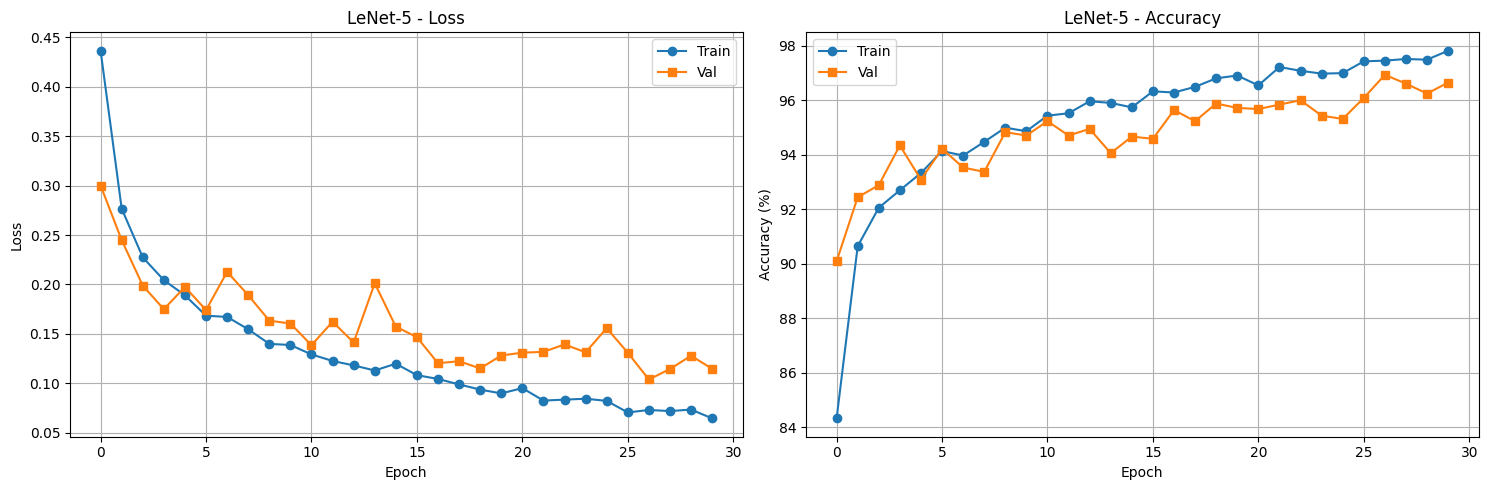

✅ Best Val Acc: 96.92%


In [6]:
# Cell 6: Visualize
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(history['train_loss'], label='Train', marker='o')
axes[0].plot(history['val_loss'], label='Val', marker='s')
axes[0].set_title(f"{model_config['model']['name']} - Loss")
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(history['train_acc'], label='Train', marker='o')
axes[1].plot(history['val_acc'], label='Val', marker='s')
axes[1].set_title(f"{model_config['model']['name']} - Accuracy")
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig(f"../results/figures/{model_config['model']['type']}_training.png", dpi=150)
plt.show()

print(f"✅ Best Val Acc: {max(history['val_acc']):.2f}%")